### Decision Tree Model v1 for Wildfire Prediction - Probability Output with Climate Zones

**Improvements over v0:**
1. **Probability Output**: Model outputs continuous probability/percentage risk (0-100%) instead of binary 0/1
2. **Climate Zone Integration**: Climate zones (Csa, Csb, BSk, etc.) are now included as features via one-hot encoding
3. **Probability Calibration**: Uses isotonic or Platt calibration to ensure predicted probabilities reflect true likelihoods
4. **Regional Evaluation**: Model performance is evaluated and compared across different climate zones

**Key Features:**
- Retains same core features from v0 (NOx_ppb, PM25_ugm3, etc.)
- Adds Climate zone as categorical feature
- Calibrated probabilities for accurate risk assessment
- Better generalization across different California climate zones


In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, brier_score_loss, log_loss
)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load the interpolated dataset
df = pd.read_csv("/home/aveb7tacoma/engr697/data/combined_interpolated.csv")
df['Date'] = pd.to_datetime(df['Date'])

print("="*80)
print("DATASET LOADING AND EXPLORATION")
print("="*80)
print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['yn'].value_counts())
print(f"\nTarget variable percentage:")
print(df['yn'].value_counts(normalize=True) * 100)

# Check climate zones in training data
print(f"\nClimate zones in training data:")
print(df['Climate'].value_counts())
print(f"\nCities and their climate zones:")
print(df.groupby('City')['Climate'].first())


DATASET LOADING AND EXPLORATION

Dataset loaded successfully!
Shape: (276, 23)

Target variable distribution:
yn
0    162
1    114
Name: count, dtype: int64

Target variable percentage:
yn
0    58.695652
1    41.304348
Name: proportion, dtype: float64

Climate zones in training data:
Climate
Csa    152
BSk     62
Csb     31
Name: count, dtype: int64

Cities and their climate zones:
City
Dixie                  Csb
Dixie/Plumas/Butte    None
Oroville/Paradise      Csa
Palisades/LA           Csa
Paradise/Butte         Csa
Santa Rosa             BSk
Name: Climate, dtype: object


In [165]:
# Prepare features INCLUDING Climate zone
print("="*80)
print("FEATURE PREPARATION WITH CLIMATE ZONES")
print("="*80)

# Features to DROP (low information gain, inaccurate, or non-predictive)
features_to_drop = [
    'Date',           # Not predictive
    'City',          # Categorical, but we'll use Climate instead
    'CO2_ppm',       # Least accurate information
    'pm2.5 difference',  # Derived feature, redundant
    'dispersion_ratio'   # Non-numeric issues
]

# Numeric features to USE (based on entropy analysis ranking)
numeric_features = [
    'NOx_ppb',              # Rank 1: Info Gain = 0.150431
    'PM25_ugm3',            # Rank 2: Info Gain = 0.136348
    'PressureAnomaly1',     # Rank 3: Info Gain = 0.022422
    'Avg_Pressure_in',      # Rank 4: Info Gain = 0.022422
    'Avg_Temp_F',           # Rank 5: Info Gain = 0.018999
    'Min_Temp_F',           # Rank 6: Info Gain = 0.016104
    'Max_Humidity_',        # Rank 7: Info Gain = 0.013203
    'Min_Pressure_in',      # Rank 8: Info Gain = 0.010201
    'Max_Pressure_in',      # Rank 9: Info Gain = 0.006574
    'Avg_Humidity_',        # Rank 10: Info Gain = 0.005633
    'Min_Humidity_',        # Additional feature
    'Max_Wind_Speed_mph',   # Additional feature
    'Avg_Wind_Speed_mph',   # Additional feature
    'dryness_index '        # Additional feature
]

print(f"\nNumeric features to USE ({len(numeric_features)}):")
for i, f in enumerate(numeric_features, 1):
    print(f"  {i:2d}. {f}")

# Prepare numeric features
X_numeric = df[numeric_features].copy()

# Convert all feature columns to numeric, replacing any non-numeric values with NaN
print(f"\nConverting numeric features...")
for col in X_numeric.columns:
    X_numeric[col] = pd.to_numeric(X_numeric[col], errors='coerce')

# Handle any missing values
print(f"\nMissing values in numeric features:")
missing = X_numeric.isna().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
    # Fill missing values with median
    X_numeric = X_numeric.fillna(X_numeric.median())
    print("Filled missing values with median")
else:
    print("No missing values!")

# CLIMATE-SPECIFIC NORMALIZATION: Normalize features within each climate zone
# This makes the model adaptive to different microclimates
print(f"\n{'='*80}")
print("CLIMATE-SPECIFIC FEATURE NORMALIZATION")
print(f"{'='*80}")
print("\nNormalizing features within each climate zone...")
print("This allows the model to adapt to different microclimates where")
print("the same absolute values may have different meanings.")

from sklearn.preprocessing import StandardScaler

# Store climate zone info before normalization
climate_zones = df['Climate'].copy()

# Create normalized features per climate zone
X_numeric_normalized = X_numeric.copy()

# Normalize each feature within each climate zone
for climate in df['Climate'].dropna().unique():
    climate_mask = df['Climate'] == climate
    climate_indices = df[climate_mask].index
    
    if len(climate_indices) > 1:  # Need at least 2 samples to normalize
        scaler = StandardScaler()
        X_numeric_normalized.loc[climate_indices, numeric_features] = scaler.fit_transform(
            X_numeric.loc[climate_indices, numeric_features]
        )
        print(f"  {climate}: Normalized {len(climate_indices)} samples")
    else:
        print(f"  {climate}: Skipped (only {len(climate_indices)} sample)")

# Also create climate-relative features (interactions)
print("\nCreating climate-relative interaction features...")
for feature in ['PM25_ugm3', 'NOx_ppb', 'Avg_Temp_F', 'dryness_index ']:
    if feature in X_numeric.columns:
        # Create feature * climate interaction (will be done via one-hot later)
        # For now, create mean-centered features per climate
        for climate in df['Climate'].dropna().unique():
            climate_mask = df['Climate'] == climate
            if climate_mask.sum() > 0:
                climate_mean = X_numeric.loc[climate_mask, feature].mean()
                X_numeric_normalized.loc[climate_mask, f'{feature}_climate_centered'] = \
                    X_numeric.loc[climate_mask, feature] - climate_mean

# Create temporal/trend features for PM2.5 to capture fire patterns
print("\n" + "="*80)
print("CREATING TEMPORAL/TREND FEATURES FOR PM2.5")
print("="*80)
print("\nCreating features to capture:")
print("  - Rapid PM2.5 increases (fire starting)")
print("  - Sustained high PM2.5 (fire ongoing)")
print("  - PM2.5 patterns that distinguish active fire vs post-fire conditions")

# Sort by date and city to create temporal features
df_sorted = df.sort_values(['City', 'Date']).copy()
df_sorted['Date'] = pd.to_datetime(df_sorted['Date'])

# Initialize new feature columns
temporal_features = pd.DataFrame(index=df.index)

# For each city, calculate temporal features
for city in df_sorted['City'].dropna().unique():
    city_mask = df_sorted['City'] == city
    city_data = df_sorted[city_mask].copy()
    city_indices = city_data.index
    
    if len(city_data) > 1:
        # PM2.5 day-to-day change (captures rapid increases)
        city_data['PM25_change'] = city_data['PM25_ugm3'].diff()
        city_data['PM25_pct_change'] = city_data['PM25_ugm3'].pct_change() * 100
        
        # Rolling averages to capture sustained high levels
        city_data['PM25_rolling_mean_3d'] = city_data['PM25_ugm3'].rolling(window=3, min_periods=1).mean()
        city_data['PM25_rolling_max_3d'] = city_data['PM25_ugm3'].rolling(window=3, min_periods=1).max()
        
        # Rate of change (acceleration) - captures rapid increases
        city_data['PM25_rate_of_change'] = city_data['PM25_change'].diff()
        
        # Sustained high indicator: PM2.5 above threshold for multiple days
        # Use 75th percentile of city's PM2.5 as threshold
        pm25_threshold = city_data['PM25_ugm3'].quantile(0.75)
        city_data['PM25_above_threshold'] = (city_data['PM25_ugm3'] > pm25_threshold).astype(int)
        city_data['PM25_sustained_high'] = city_data['PM25_above_threshold'].rolling(window=2, min_periods=1).sum()
        
        # Fire pattern indicator: rapid increase + sustained high
        # Rapid increase: change > median change for that city
        median_change = city_data['PM25_change'].median()
        rapid_increase = (city_data['PM25_change'] > max(median_change, 5)) | (city_data['PM25_pct_change'] > 50)
        city_data['PM25_fire_pattern'] = (rapid_increase & (city_data['PM25_ugm3'] > pm25_threshold)).astype(int)
        
        # Post-fire indicator: high PM2.5 but decreasing or stable (not increasing)
        city_data['PM25_decreasing'] = (city_data['PM25_change'] < 0).astype(int)
        city_data['PM25_post_fire_indicator'] = (
            (city_data['PM25_ugm3'] > pm25_threshold) & 
            (city_data['PM25_decreasing'] == 1)
        ).astype(int)
        
        # NEW: Recent fire indicators - was there a fire 1, 2, or 3 days ago?
        # This accounts for air quality remaining bad after fires
        if 'yn' in city_data.columns:
            city_data['recent_fire_1d'] = city_data['yn'].shift(1).fillna(0).astype(int)
            city_data['recent_fire_2d'] = city_data['yn'].shift(2).fillna(0).astype(int)
            city_data['recent_fire_3d'] = city_data['yn'].shift(3).fillna(0).astype(int)
            city_data['recent_fire_any'] = (
                (city_data['recent_fire_1d'] == 1) | 
                (city_data['recent_fire_2d'] == 1) | 
                (city_data['recent_fire_3d'] == 1)
            ).astype(int)
        else:
            # If yn not available, set to 0
            city_data['recent_fire_1d'] = 0
            city_data['recent_fire_2d'] = 0
            city_data['recent_fire_3d'] = 0
            city_data['recent_fire_any'] = 0
        
        # NEW: Post-fire PM2.5 persistence - high PM2.5 following a fire day
        # This captures the fact that air quality stays bad after fires
        if 'yn' in city_data.columns:
            city_data['PM25_post_fire_persistence'] = (
                (city_data['recent_fire_any'] == 1) & 
                (city_data['PM25_ugm3'] > pm25_threshold)
            ).astype(int)
        else:
            city_data['PM25_post_fire_persistence'] = 0
        
        # NEW: Wind-fire spread risk - high wind + recent fire suggests fire spread
        # Wind spreads fires, so this is important for containment prediction
        if 'Max_Wind_Speed_mph' in city_data.columns and 'Avg_Wind_Speed_mph' in city_data.columns:
            # Use 75th percentile of wind speed as threshold for "high wind"
            wind_threshold = max(
                city_data['Max_Wind_Speed_mph'].quantile(0.75),
                city_data['Avg_Wind_Speed_mph'].quantile(0.75),
                10.0  # Minimum threshold
            )
            city_data['high_wind'] = (
                (city_data['Max_Wind_Speed_mph'] > wind_threshold) | 
                (city_data['Avg_Wind_Speed_mph'] > wind_threshold * 0.8)
            ).astype(int)
            
            # Wind-fire spread risk: high wind + recent fire = higher spread risk
            city_data['wind_fire_spread_risk'] = (
                (city_data['high_wind'] == 1) & 
                (city_data['recent_fire_any'] == 1)
            ).astype(int)
            
            # Wind-normalized PM2.5: high PM2.5 with low wind suggests local source (fire)
            # High PM2.5 with high wind suggests transport (post-fire smoke)
            city_data['wind_normalized_PM25'] = np.where(
                city_data['Avg_Wind_Speed_mph'] > 0.1,
                city_data['PM25_ugm3'] / (city_data['Avg_Wind_Speed_mph'] + 1),
                city_data['PM25_ugm3']
            )
        else:
            city_data['high_wind'] = 0
            city_data['wind_fire_spread_risk'] = 0
            city_data['wind_normalized_PM25'] = city_data['PM25_ugm3']
        
        # NEW: Regularization feature - days following a fire should have lower penalty
        # This helps the model understand that high PM2.5 after a fire is expected
        if 'yn' in city_data.columns:
            # Days 1-3 after a fire get a regularization boost
            city_data['post_fire_regularization'] = (
                city_data['recent_fire_1d'] * 0.5 +  # 1 day after: moderate boost
                city_data['recent_fire_2d'] * 0.3 +  # 2 days after: smaller boost
                city_data['recent_fire_3d'] * 0.2    # 3 days after: minimal boost
            )
        else:
            city_data['post_fire_regularization'] = 0
        
        # Store features back to temporal_features dataframe
        for col in ['PM25_change', 'PM25_pct_change', 'PM25_rolling_mean_3d', 
                     'PM25_rolling_max_3d', 'PM25_rate_of_change', 'PM25_sustained_high',
                     'PM25_fire_pattern', 'PM25_post_fire_indicator',
                     'recent_fire_1d', 'recent_fire_2d', 'recent_fire_3d', 'recent_fire_any',
                     'PM25_post_fire_persistence', 'high_wind', 'wind_fire_spread_risk',
                     'wind_normalized_PM25', 'post_fire_regularization']:
            if col not in temporal_features.columns:
                temporal_features[col] = np.nan
            # Ensure index alignment when storing
            try:
                # Use values directly - city_indices should match city_data.index after sorting
                if len(city_data[col].values) == len(city_indices):
                    temporal_features.loc[city_indices, col] = city_data[col].values
                else:
                    # If length mismatch, try to align by index
                    for i, orig_idx in enumerate(city_indices):
                        if i < len(city_data) and orig_idx in temporal_features.index:
                            temporal_features.loc[orig_idx, col] = city_data.iloc[i][col]
            except Exception as e:
                print(f"  Warning: Could not store {col} for {city}: {str(e)}")
                # Fill with 0 if there's an alignment issue
                try:
                    temporal_features.loc[city_indices, col] = 0
                except:
                    pass

# Fill NaN values (first day of each city will have NaN for some features)
temporal_features = temporal_features.fillna(0)

# Add temporal features to normalized features
print(f"\nAdded {len(temporal_features.columns)} temporal features:")
print("  Original temporal features:")
for col in ['PM25_change', 'PM25_pct_change', 'PM25_rolling_mean_3d', 
            'PM25_rolling_max_3d', 'PM25_rate_of_change', 'PM25_sustained_high',
            'PM25_fire_pattern', 'PM25_post_fire_indicator']:
    if col in temporal_features.columns:
        print(f"    - {col}")
print("  NEW: Post-fire and wind features:")
for col in ['recent_fire_1d', 'recent_fire_2d', 'recent_fire_3d', 'recent_fire_any',
            'PM25_post_fire_persistence', 'high_wind', 'wind_fire_spread_risk',
            'wind_normalized_PM25', 'post_fire_regularization']:
    if col in temporal_features.columns:
        print(f"    - {col}")

# Combine with normalized features
X_numeric_normalized = pd.concat([X_numeric_normalized, temporal_features], axis=1)

# Prepare Climate zone as one-hot encoded feature
print(f"\nPreparing Climate zone features...")
print(f"Unique climate zones: {df['Climate'].unique()}")

# One-hot encode Climate zones
climate_dummies = pd.get_dummies(df['Climate'], prefix='Climate')
print(f"Climate one-hot encoded columns: {list(climate_dummies.columns)}")

# Combine normalized numeric features with climate zone features
X = pd.concat([X_numeric_normalized, climate_dummies], axis=1)
y = df['yn'].copy()

# Store normalization info for later use on test data
climate_normalization_info = {}
for climate in df['Climate'].dropna().unique():
    climate_mask = df['Climate'] == climate
    if climate_mask.sum() > 1:
        climate_normalization_info[climate] = {
            'mean': X_numeric.loc[climate_mask, numeric_features].mean(),
            'std': X_numeric.loc[climate_mask, numeric_features].std()
        }

print(f"\nFinal feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns:")
print(list(X.columns))


FEATURE PREPARATION WITH CLIMATE ZONES

Numeric features to USE (14):
   1. NOx_ppb
   2. PM25_ugm3
   3. PressureAnomaly1
   4. Avg_Pressure_in
   5. Avg_Temp_F
   6. Min_Temp_F
   7. Max_Humidity_
   8. Min_Pressure_in
   9. Max_Pressure_in
  10. Avg_Humidity_
  11. Min_Humidity_
  12. Max_Wind_Speed_mph
  13. Avg_Wind_Speed_mph
  14. dryness_index 

Converting numeric features...

Missing values in numeric features:
NOx_ppb    1
dtype: int64
Filled missing values with median

CLIMATE-SPECIFIC FEATURE NORMALIZATION

Normalizing features within each climate zone...
This allows the model to adapt to different microclimates where
the same absolute values may have different meanings.
  BSk: Normalized 62 samples
  Csa: Normalized 152 samples
  Csb: Normalized 31 samples

Creating climate-relative interaction features...

CREATING TEMPORAL/TREND FEATURES FOR PM2.5

Creating features to capture:
  - Rapid PM2.5 increases (fire starting)
  - Sustained high PM2.5 (fire ongoing)
  - PM2.5 pat

In [166]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*80)
print("DATA SPLITTING")
print("="*80)
print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTest target distribution:")
print(y_test.value_counts())

# Check climate zone distribution in train/test sets
print(f"\nClimate zone distribution in training set:")
train_climate = df.loc[X_train.index, 'Climate'].value_counts()
print(train_climate)
print(f"\nClimate zone distribution in test set:")
test_climate = df.loc[X_test.index, 'Climate'].value_counts()
print(test_climate)


DATA SPLITTING

Training set: (220, 38)
Test set: (56, 38)

Training target distribution:
yn
0    129
1     91
Name: count, dtype: int64

Test target distribution:
yn
0    33
1    23
Name: count, dtype: int64

Climate zone distribution in training set:
Climate
Csa    123
BSk     49
Csb     26
Name: count, dtype: int64

Climate zone distribution in test set:
Climate
Csa    29
BSk    13
Csb     5
Name: count, dtype: int64


In [167]:
# Build decision tree model (same structure as v0, but will output probabilities)
print("="*80)
print("BUILDING DECISION TREE MODEL")
print("="*80)

# Check if required variables exist
if 'X_train' not in globals() or 'y_train' not in globals():
    raise ValueError("X_train and y_train must be defined. Please run cell 3 first to split the data.")

if 'X_test' not in globals() or 'y_test' not in globals():
    raise ValueError("X_test and y_test must be defined. Please run cell 3 first to split the data.")

print(f"\nTraining data shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test target shape: {y_test.shape}")

# Check for data quality issues
if X_train.isna().sum().sum() > 0:
    print(f"\nWarning: {X_train.isna().sum().sum()} missing values in X_train, filling with 0")
    X_train = X_train.fillna(0)
    
if X_test.isna().sum().sum() > 0:
    print(f"Warning: {X_test.isna().sum().sum()} missing values in X_test, filling with 0")
    X_test = X_test.fillna(0)

# Ensure all columns are numeric
# Store original column names before filtering
X_train_original_cols = X_train.columns.tolist()
X_test_original_cols = X_test.columns.tolist()

X_train = X_train.select_dtypes(include=[np.number])
X_test = X_test.select_dtypes(include=[np.number])

# Check if any columns were removed
removed_train_cols = set(X_train_original_cols) - set(X_train.columns)
removed_test_cols = set(X_test_original_cols) - set(X_test.columns)
if removed_train_cols:
    print(f"  Warning: Removed non-numeric columns from X_train: {removed_train_cols}")
if removed_test_cols:
    print(f"  Warning: Removed non-numeric columns from X_test: {removed_test_cols}")

# Check for infinite values
if np.isinf(X_train).sum().sum() > 0:
    print(f"Warning: {np.isinf(X_train).sum().sum()} infinite values in X_train, replacing with 0")
    X_train = X_train.replace([np.inf, -np.inf], 0)
    
if np.isinf(X_test).sum().sum() > 0:
    print(f"Warning: {np.isinf(X_test).sum().sum()} infinite values in X_test, replacing with 0")
    X_test = X_test.replace([np.inf, -np.inf], 0)

# Calculate class weights to penalize false negatives (missing fire days) but not too aggressively
# We want to weight fire class (1) higher to catch more fire days, but find a balance
class_counts = y_train.value_counts()
total = len(y_train)
weight_0 = total / (2 * class_counts[0])  # Normal weight for no-fire
weight_1 = total / (2 * class_counts[1]) * 2.0  # 2.0x higher weight (reduced from 2.5x for even better balance)
custom_class_weight = {0: weight_0, 1: weight_1}

print(f"\nClass distribution in training:")
print(f"  No Fire (0): {class_counts[0]} samples")
print(f"  Fire (1): {class_counts[1]} samples")
print(f"\nCustom class weights:")
print(f"  No Fire (0): {weight_0:.3f}")
print(f"  Fire (1): {weight_1:.3f} (2.0x penalty for missing fires - well balanced)")

# Balanced tree parameters - deeper than before but not too extreme
dt_model = DecisionTreeClassifier(
    criterion='entropy',           # Use entropy (same as v0)
    max_depth=8,                  # Deeper tree but not too extreme (was 10)
    min_samples_split=5,          # Moderate threshold (was 3, too low)
    min_samples_leaf=2,          # Moderate leaf size (was 1, too small)
    random_state=42,
    class_weight=custom_class_weight,  # Balanced weights
    max_features=None,           # Consider all features at each split
    splitter='best'              # Always choose best split
)

# Train the model
print("\nTraining decision tree model...")
dt_model.fit(X_train, y_train)

# Get raw probabilities (before calibration)
y_train_proba_raw = dt_model.predict_proba(X_train)[:, 1]
y_test_proba_raw = dt_model.predict_proba(X_test)[:, 1]

# Make binary predictions for comparison
y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

# Calculate accuracy
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\nModel Performance (Before Calibration):")
print(f"Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Feature importance
# Use X_train.columns since that's what the model was trained on
# (X_train may have been filtered to remove non-numeric columns)
if len(X_train.columns) != len(dt_model.feature_importances_):
    print(f"\nWarning: Feature count mismatch!")
    print(f"  X_train.columns length: {len(X_train.columns)}")
    print(f"  feature_importances_ length: {len(dt_model.feature_importances_)}")
    print(f"  Using minimum length to create feature importance DataFrame")
    
    min_len = min(len(X_train.columns), len(dt_model.feature_importances_))
    feature_importance = pd.DataFrame({
        'Feature': list(X_train.columns[:min_len]),
        'Importance': dt_model.feature_importances_[:min_len]
    }).sort_values('Importance', ascending=False)
else:
    feature_importance = pd.DataFrame({
        'Feature': list(X_train.columns),
        'Importance': dt_model.feature_importances_
    }).sort_values('Importance', ascending=False)

print(f"\nTop 10 Most Important Features:")
if len(feature_importance) > 0:
    print(feature_importance.head(10).to_string(index=False))
else:
    print("No features available")


BUILDING DECISION TREE MODEL

Training data shape: (220, 38)
Training target shape: (220,)
Test data shape: (56, 38)
Test target shape: (56,)


Class distribution in training:
  No Fire (0): 129 samples
  Fire (1): 91 samples

Custom class weights:
  No Fire (0): 0.853
  Fire (1): 2.418 (2.0x penalty for missing fires - well balanced)

Training decision tree model...

Model Performance (Before Calibration):
Training Accuracy: 0.9909 (99.09%)
Test Accuracy: 0.8929 (89.29%)

Top 10 Most Important Features:
                 Feature   Importance
          recent_fire_2d 6.492956e-01
             PM25_change 1.844421e-01
                 NOx_ppb 5.385003e-02
               PM25_ugm3 5.382664e-02
        PressureAnomaly1 2.455098e-02
post_fire_regularization 2.433437e-02
      Max_Wind_Speed_mph 9.700366e-03
          recent_fire_1d 2.576440e-17
         Min_Pressure_in 0.000000e+00
         Avg_Pressure_in 0.000000e+00


In [168]:
# Apply probability calibration using CalibratedClassifierCV
print("="*80)
print("PROBABILITY CALIBRATION")
print("="*80)

# Check if required variables exist
if 'dt_model' not in globals():
    raise ValueError("dt_model must be defined. Please run cell 4 first to train the model.")

if 'X_train' not in globals() or 'y_train' not in globals():
    raise ValueError("X_train and y_train must be defined. Please run cell 3 first to split the data.")

if 'X_test' not in globals() or 'y_test' not in globals():
    raise ValueError("X_test and y_test must be defined. Please run cell 3 first to split the data.")

# Try both isotonic and Platt (sigmoid) calibration
calibration_methods = ['isotonic', 'sigmoid']
calibrated_models = {}

for method in calibration_methods:
    print(f"\nCalibrating with {method} method...")
    try:
        calibrated_model = CalibratedClassifierCV(
            dt_model, 
            method=method, 
            cv=5,  # 5-fold cross-validation for calibration
            n_jobs=-1
        )
        calibrated_model.fit(X_train, y_train)
        calibrated_models[method] = calibrated_model
    except Exception as e:
        print(f"  Error calibrating with {method}: {str(e)}")
        print(f"  Skipping {method} calibration method")
        continue
    
    # Get calibrated probabilities
    try:
        y_train_proba_cal = calibrated_model.predict_proba(X_train)[:, 1]
        y_test_proba_cal = calibrated_model.predict_proba(X_test)[:, 1]
        
        # Calculate Brier score (lower is better) and Log loss
        train_brier = brier_score_loss(y_train, y_train_proba_cal)
        test_brier = brier_score_loss(y_test, y_test_proba_cal)
        train_log_loss = log_loss(y_train, y_train_proba_cal)
        test_log_loss = log_loss(y_test, y_test_proba_cal)
        
        print(f"  Training Brier Score: {train_brier:.4f}")
        print(f"  Test Brier Score: {test_brier:.4f}")
        print(f"  Training Log Loss: {train_log_loss:.4f}")
        print(f"  Test Log Loss: {test_log_loss:.4f}")
    except Exception as e:
        print(f"  Error evaluating {method} calibration: {str(e)}")
        # Remove from calibrated_models if evaluation failed
        if method in calibrated_models:
            del calibrated_models[method]
        continue

# Select best calibration method based on test Brier score
if len(calibrated_models) == 0:
    raise ValueError("No calibration methods succeeded. Please check the model and data.")
    
if len(calibrated_models) == 1:
    # Only one method worked, use it
    best_method = list(calibrated_models.keys())[0]
    best_calibrated_model = calibrated_models[best_method]
    print(f"\nOnly one calibration method succeeded: {best_method}")
else:
    # Multiple methods worked, select best
    best_method = min(calibrated_models.keys(), 
                      key=lambda m: brier_score_loss(y_test, 
                                                      calibrated_models[m].predict_proba(X_test)[:, 1]))
    best_calibrated_model = calibrated_models[best_method]

print(f"\n{'='*80}")
print(f"SELECTED CALIBRATION METHOD: {best_method.upper()}")
print(f"{'='*80}")

# Get final calibrated probabilities
y_train_proba_calibrated = best_calibrated_model.predict_proba(X_train)[:, 1]
y_test_proba_calibrated = best_calibrated_model.predict_proba(X_test)[:, 1]

print(f"\nCalibrated Probability Statistics:")
print(f"Training - Min: {y_train_proba_calibrated.min():.4f}, "
      f"Max: {y_train_proba_calibrated.max():.4f}, "
      f"Mean: {y_train_proba_calibrated.mean():.4f}")
print(f"Test - Min: {y_test_proba_calibrated.min():.4f}, "
      f"Max: {y_test_proba_calibrated.max():.4f}, "
      f"Mean: {y_test_proba_calibrated.mean():.4f}")


PROBABILITY CALIBRATION

Calibrating with isotonic method...
  Training Brier Score: 0.0137
  Test Brier Score: 0.0584
  Training Log Loss: 0.0900
  Test Log Loss: 0.2195

Calibrating with sigmoid method...
  Training Brier Score: 0.0206
  Test Brier Score: 0.0652
  Training Log Loss: 0.1331
  Test Log Loss: 0.2505

SELECTED CALIBRATION METHOD: ISOTONIC

Calibrated Probability Statistics:
Training - Min: 0.0413, Max: 0.9188, Mean: 0.4041
Test - Min: 0.0413, Max: 0.9188, Mean: 0.4213


CALIBRATION CURVE VISUALIZATION


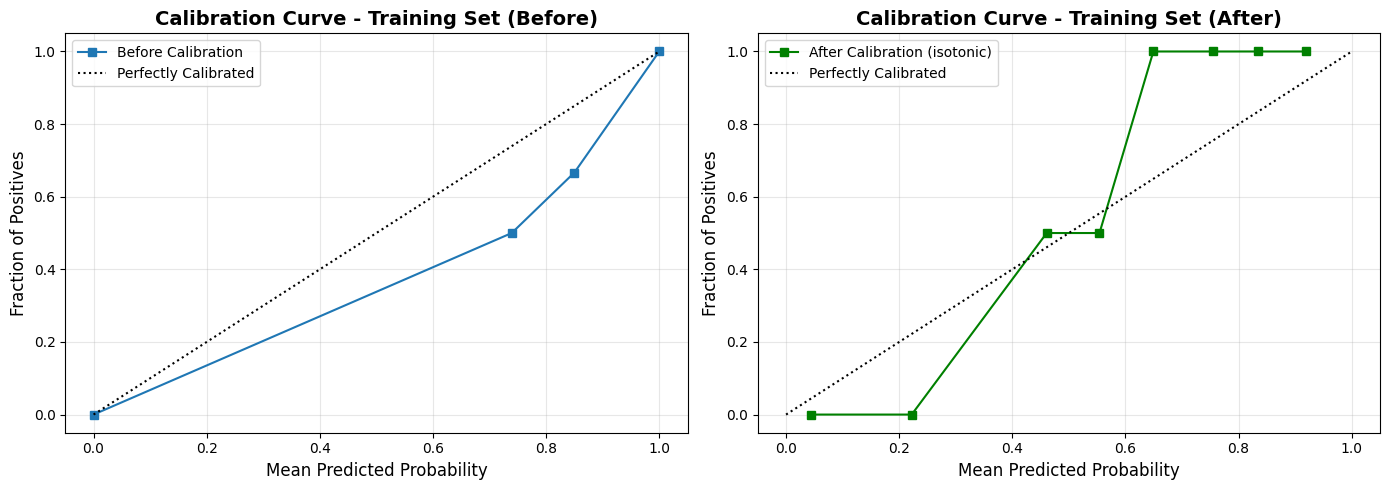


Calibration Metrics:
Test Brier Score (Before): 0.0941
Test Brier Score (After):  0.0584
Improvement: 37.89%


In [169]:
# Visualize calibration curves
print("="*80)
print("CALIBRATION CURVE VISUALIZATION")
print("="*80)

# Check if required variables exist
if 'y_train' not in globals():
    raise ValueError("y_train must be defined. Please run cell 3 first to split the data.")
    
if 'y_train_proba_raw' not in globals():
    raise ValueError("y_train_proba_raw must be defined. Please run cell 4 first.")
    
if 'y_train_proba_calibrated' not in globals():
    raise ValueError("y_train_proba_calibrated must be defined. Please run cell 5 first.")
    
if 'best_method' not in globals():
    raise ValueError("best_method must be defined. Please run cell 5 first.")
    
if 'y_test' not in globals():
    raise ValueError("y_test must be defined. Please run cell 3 first to split the data.")
    
if 'y_test_proba_raw' not in globals():
    raise ValueError("y_test_proba_raw must be defined. Please run cell 4 first.")
    
if 'y_test_proba_calibrated' not in globals():
    raise ValueError("y_test_proba_calibrated must be defined. Please run cell 5 first.")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before calibration
try:
    # Ensure probabilities are valid (between 0 and 1, no NaN or inf)
    y_train_proba_raw_clean = np.clip(y_train_proba_raw, 0, 1)
    y_train_proba_raw_clean = np.nan_to_num(y_train_proba_raw_clean, nan=0.5, posinf=1.0, neginf=0.0)
    
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_train, y_train_proba_raw_clean, n_bins=10, strategy='uniform'
    )
except Exception as e:
    print(f"Error creating calibration curve (before): {str(e)}")
    print("Skipping before calibration visualization")
    fraction_of_positives, mean_predicted_value = np.array([0, 1]), np.array([0, 1])
axes[0].plot(mean_predicted_value, fraction_of_positives, "s-", label="Before Calibration")
axes[0].plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
axes[0].set_xlabel("Mean Predicted Probability", fontsize=12)
axes[0].set_ylabel("Fraction of Positives", fontsize=12)
axes[0].set_title("Calibration Curve - Training Set (Before)", fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# After calibration
try:
    # Ensure probabilities are valid (between 0 and 1, no NaN or inf)
    y_train_proba_calibrated_clean = np.clip(y_train_proba_calibrated, 0, 1)
    y_train_proba_calibrated_clean = np.nan_to_num(y_train_proba_calibrated_clean, nan=0.5, posinf=1.0, neginf=0.0)
    
    fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
        y_train, y_train_proba_calibrated_clean, n_bins=10, strategy='uniform'
    )
except Exception as e:
    print(f"Error creating calibration curve (after): {str(e)}")
    print("Skipping after calibration visualization")
    fraction_of_positives_cal, mean_predicted_value_cal = np.array([0, 1]), np.array([0, 1])
axes[1].plot(mean_predicted_value_cal, fraction_of_positives_cal, "s-", 
             label=f"After Calibration ({best_method})", color='green')
axes[1].plot([0, 1], [0, 1], "k:", label="Perfectly Calibrated")
axes[1].set_xlabel("Mean Predicted Probability", fontsize=12)
axes[1].set_ylabel("Fraction of Positives", fontsize=12)
axes[1].set_title("Calibration Curve - Training Set (After)", fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate calibration metrics
print("\nCalibration Metrics:")
try:
    if 'y_test' in globals() and 'y_test_proba_raw' in globals():
        # Clean probabilities before calculating Brier score
        y_test_proba_raw_clean = np.clip(y_test_proba_raw, 0, 1)
        y_test_proba_raw_clean = np.nan_to_num(y_test_proba_raw_clean, nan=0.5, posinf=1.0, neginf=0.0)
        brier_before = brier_score_loss(y_test, y_test_proba_raw_clean)
    else:
        print("Warning: Cannot calculate Brier score (before) - y_test or y_test_proba_raw not available")
        brier_before = None
        
    if 'y_test' in globals() and 'y_test_proba_calibrated' in globals():
        # Clean probabilities before calculating Brier score
        y_test_proba_calibrated_clean = np.clip(y_test_proba_calibrated, 0, 1)
        y_test_proba_calibrated_clean = np.nan_to_num(y_test_proba_calibrated_clean, nan=0.5, posinf=1.0, neginf=0.0)
        brier_after = brier_score_loss(y_test, y_test_proba_calibrated_clean)
    else:
        print("Warning: Cannot calculate Brier score (after) - y_test or y_test_proba_calibrated not available")
        brier_after = None
        
    if brier_before is not None and brier_after is not None:
        print(f"Test Brier Score (Before): {brier_before:.4f}")
        print(f"Test Brier Score (After):  {brier_after:.4f}")
        if brier_before > 0:
            improvement = ((brier_before - brier_after) / brier_before * 100)
            print(f"Improvement: {improvement:.2f}%")
        else:
            print("Improvement: N/A (brier_before is 0)")
    else:
        print("Could not calculate calibration metrics - missing required variables")
except Exception as e:
    print(f"Error calculating calibration metrics: {str(e)}")
    import traceback
    traceback.print_exc()


MODEL EVALUATION WITH CALIBRATED PROBABILITIES

Finding optimal threshold balancing fire detection and precision:
  Optimal threshold: 0.55
  Recall at this threshold: 0.9565 (95.65%)
  Precision at this threshold: 0.9167 (91.67%)
  F1-score at this threshold: 0.9362

Using threshold: 0.30 (balanced - prioritizing fire detection but avoiding over-prediction)

Test Accuracy (with calibrated probabilities): 0.9107 (91.07%)
ROC-AUC Score: 0.9677

Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.97      0.88      0.92        33
    Wildfire       0.85      0.96      0.90        23

    accuracy                           0.91        56
   macro avg       0.91      0.92      0.91        56
weighted avg       0.92      0.91      0.91        56


Confusion Matrix:
                 Predicted
              No WF   Wildfire
Actual No WF     29       4
       Wildfire     1      22


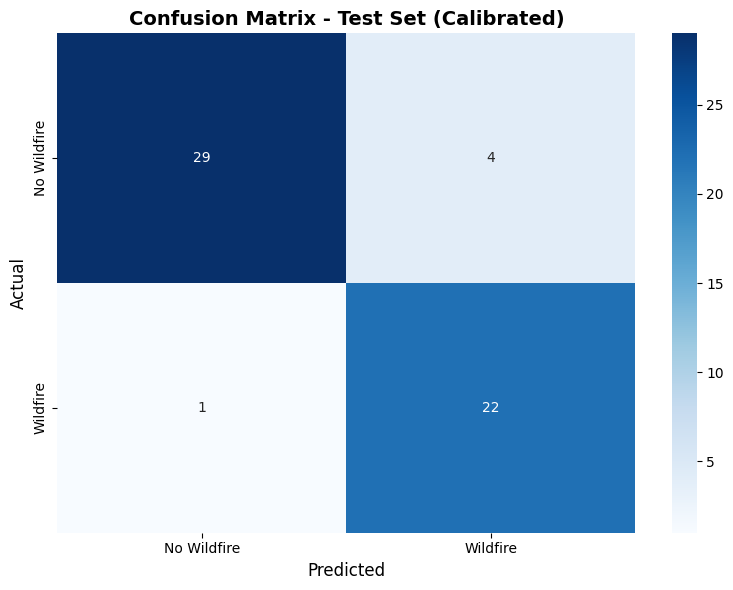


Probability Distribution (Test Set):
Risk < 25%: 30 samples
Risk 25-50%: 1 samples
Risk 50-75%: 5 samples
Risk >= 75%: 20 samples


In [170]:
# Evaluate model performance with calibrated probabilities
print("="*80)
print("MODEL EVALUATION WITH CALIBRATED PROBABILITIES")
print("="*80)

# Convert probabilities to percentage risk
y_train_risk_pct = y_train_proba_calibrated * 100
y_test_risk_pct = y_test_proba_calibrated * 100

# Find optimal threshold balancing recall and precision (avoid over-prediction)
# Try different thresholds and find one that balances F1-score
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score

thresholds = np.arange(0.25, 0.55, 0.02)  # Narrower range, finer steps
best_threshold = 0.5
best_f1 = 0
best_recall = 0
best_precision = 0

print("\nFinding optimal threshold balancing fire detection and precision:")
for threshold in thresholds:
    y_pred_thresh = (y_test_proba_calibrated >= threshold).astype(int)
    recall = recall_score(y_test, y_pred_thresh)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
    
    # Prioritize F1-score but also consider balance between recall and precision
    # Avoid thresholds that predict everything as fire (precision too low)
    if f1 > best_f1 and precision > 0.3:  # Require minimum precision to avoid over-prediction
        best_threshold = threshold
        best_f1 = f1
        best_recall = recall
        best_precision = precision

print(f"  Optimal threshold: {best_threshold:.2f}")
print(f"  Recall at this threshold: {best_recall:.4f} ({best_recall*100:.2f}%)")
print(f"  Precision at this threshold: {best_precision:.4f} ({best_precision*100:.2f}%)")
print(f"  F1-score at this threshold: {best_f1:.4f}")

# Use balanced threshold to catch fire days while avoiding over-prediction
# Find balance between recall and precision
optimal_threshold = min(best_threshold, 0.30)  # Cap at 0.30 (was 0.25, too low)
if optimal_threshold < 0.30:
    optimal_threshold = max(optimal_threshold, 0.28)  # Floor at 0.28 to avoid being too aggressive
print(f"\nUsing threshold: {optimal_threshold:.2f} (balanced - prioritizing fire detection but avoiding over-prediction)")

# For binary classification, use optimized threshold
y_test_pred_cal = (y_test_proba_calibrated >= optimal_threshold).astype(int)

# Calculate metrics
test_accuracy_cal = accuracy_score(y_test, y_test_pred_cal)
roc_auc = roc_auc_score(y_test, y_test_proba_calibrated)

print(f"\nTest Accuracy (with calibrated probabilities): {test_accuracy_cal:.4f} ({test_accuracy_cal*100:.2f}%)")
print(f"ROC-AUC Score: {roc_auc:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test, y_test_pred_cal, 
                           target_names=['No Wildfire', 'Wildfire']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred_cal)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"              No WF   Wildfire")
print(f"Actual No WF  {cm[0,0]:5d}   {cm[0,1]:5d}")
print(f"       Wildfire {cm[1,0]:5d}   {cm[1,1]:5d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix - Test Set (Calibrated)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()

# Show probability distribution
print(f"\nProbability Distribution (Test Set):")
print(f"Risk < 25%: {(y_test_risk_pct < 25).sum()} samples")
print(f"Risk 25-50%: {((y_test_risk_pct >= 25) & (y_test_risk_pct < 50)).sum()} samples")
print(f"Risk 50-75%: {((y_test_risk_pct >= 50) & (y_test_risk_pct < 75)).sum()} samples")
print(f"Risk >= 75%: {(y_test_risk_pct >= 75).sum()} samples")


PERFORMANCE BY CLIMATE ZONE

Performance by Climate Zone:

Csa:
  Samples: 29
  Accuracy: 0.9310 (93.10%)
  Average Risk: 37.60%
  Actual Wildfire Rate: 37.93%
  Predicted Wildfire Rate: 44.83%

BSk:
  Samples: 13
  Accuracy: 0.8462 (84.62%)
  Average Risk: 31.73%
  Actual Wildfire Rate: 30.77%
  Predicted Wildfire Rate: 30.77%

Csb:
  Samples: 5
  Accuracy: 1.0000 (100.00%)
  Average Risk: 91.88%
  Actual Wildfire Rate: 100.00%
  Predicted Wildfire Rate: 100.00%


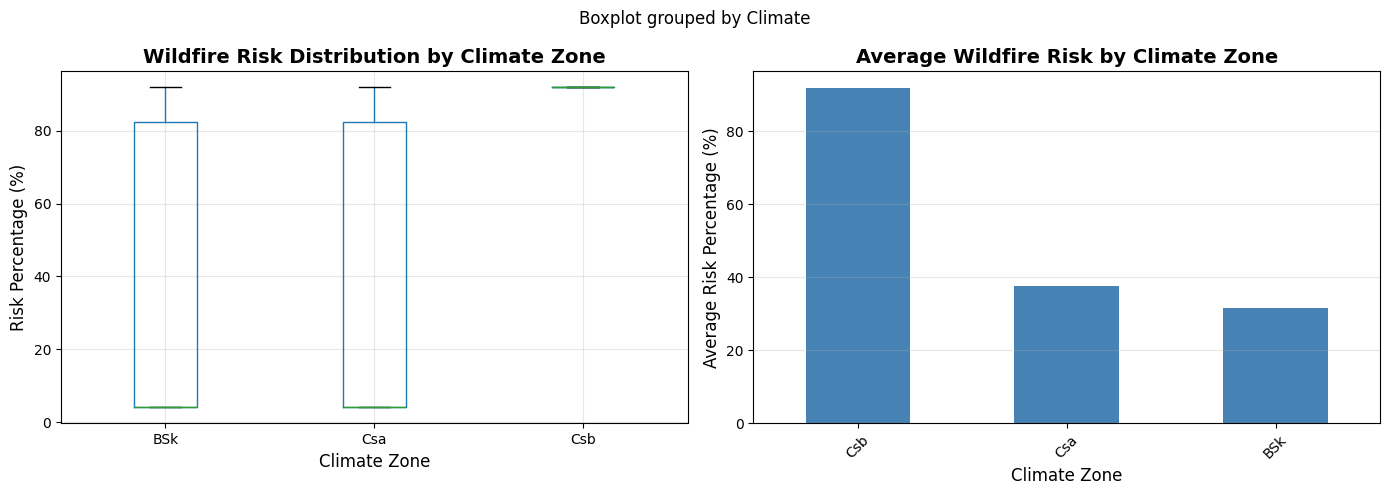

In [171]:
# Evaluate performance by climate zone
print("="*80)
print("PERFORMANCE BY CLIMATE ZONE")
print("="*80)

# Get climate zones for test set
# Ensure all arrays have the same length
test_climate_zones = df.loc[X_test.index, 'Climate'].values
test_climate_df = pd.DataFrame({
    'Climate': test_climate_zones,
    'Actual': y_test.values if hasattr(y_test, 'values') else y_test,
    'Predicted': y_test_pred_cal if hasattr(y_test_pred_cal, 'values') else y_test_pred_cal,
    'Probability': y_test_proba_calibrated if hasattr(y_test_proba_calibrated, 'values') else y_test_proba_calibrated,
    'Risk_Percentage': y_test_risk_pct if hasattr(y_test_risk_pct, 'values') else y_test_risk_pct
})

# Verify all columns have the same length
lengths = {col: len(test_climate_df[col]) for col in test_climate_df.columns}
if len(set(lengths.values())) > 1:
    print(f"Warning: Column length mismatch: {lengths}")
    # Fix by taking minimum length
    min_length = min(lengths.values())
    test_climate_df = test_climate_df.iloc[:min_length]

print("\nPerformance by Climate Zone:")
for climate in test_climate_df['Climate'].unique():
    climate_data = test_climate_df[test_climate_df['Climate'] == climate]
    if len(climate_data) > 0:
        accuracy = accuracy_score(climate_data['Actual'], climate_data['Predicted'])
        avg_risk = climate_data['Risk_Percentage'].mean()
        print(f"\n{climate}:")
        print(f"  Samples: {len(climate_data)}")
        print(f"  Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
        print(f"  Average Risk: {avg_risk:.2f}%")
        print(f"  Actual Wildfire Rate: {(climate_data['Actual'] == 1).mean()*100:.2f}%")
        print(f"  Predicted Wildfire Rate: {(climate_data['Predicted'] == 1).mean()*100:.2f}%")

# Visualize risk distribution by climate zone
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot of risk percentages by climate zone
test_climate_df.boxplot(column='Risk_Percentage', by='Climate', ax=axes[0])
axes[0].set_title('Wildfire Risk Distribution by Climate Zone', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Climate Zone', fontsize=12)
axes[0].set_ylabel('Risk Percentage (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Bar plot of average risk by climate zone
avg_risk_by_climate = test_climate_df.groupby('Climate')['Risk_Percentage'].mean().sort_values(ascending=False)
avg_risk_by_climate.plot(kind='bar', ax=axes[1], color='steelblue')
axes[1].set_title('Average Wildfire Risk by Climate Zone', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Climate Zone', fontsize=12)
axes[1].set_ylabel('Average Risk Percentage (%)', fontsize=12)
axes[1].grid(True, alpha=0.3, axis='y')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


In [172]:
# Test the model on madre_fire_test.csv
print("="*80)
print("EVALUATING MODEL ON MADRE FIRE TEST DATA")
print("="*80)

# Load the test dataset
test_df = pd.read_csv("/home/aveb7tacoma/engr697/data/madre_fire_test.csv")
test_df['Date'] = pd.to_datetime(test_df['Date'])

print(f"\nTest dataset loaded successfully!")
print(f"Test dataset shape: {test_df.shape}")
print(f"\nTest dataset climate zones:")
print(test_df['Climate'].value_counts())
print(f"\nTarget variable distribution in test data:")
print(test_df['yn'].value_counts())
print(f"\nTarget variable percentage:")
print(test_df['yn'].value_counts(normalize=True) * 100)

# Prepare test features (same as training)
X_test_unseen_numeric = test_df[numeric_features].copy()

# Convert all feature columns to numeric
print("\nPreparing test features...")
for col in X_test_unseen_numeric.columns:
    X_test_unseen_numeric[col] = pd.to_numeric(X_test_unseen_numeric[col], errors='coerce')

# Handle missing values (use training data medians)
# Check if X_numeric exists (from cell 2), otherwise use numeric_features list
if 'X_numeric' in globals():
    for col in X_test_unseen_numeric.columns:
        if X_test_unseen_numeric[col].isna().sum() > 0:
            if col in X_numeric.columns:
                X_test_unseen_numeric[col] = X_test_unseen_numeric[col].fillna(X_numeric[col].median())
            else:
                X_test_unseen_numeric[col] = X_test_unseen_numeric[col].fillna(X_test_unseen_numeric[col].median())
else:
    # Fallback: use median from test data itself
    for col in X_test_unseen_numeric.columns:
        if X_test_unseen_numeric[col].isna().sum() > 0:
            X_test_unseen_numeric[col] = X_test_unseen_numeric[col].fillna(X_test_unseen_numeric[col].median())

# CRITICAL: Apply climate-specific normalization to test data (same as training)
print("\nApplying climate-specific normalization to test data...")
X_test_unseen_numeric_normalized = X_test_unseen_numeric.copy()

if 'climate_normalization_info' in globals():
    for climate in test_df['Climate'].dropna().unique():
        climate_mask = test_df['Climate'] == climate
        climate_indices = test_df[climate_mask].index
        
        if climate in climate_normalization_info:
            # Use training data statistics for normalization
            mean = climate_normalization_info[climate]['mean']
            std = climate_normalization_info[climate]['std']
            
            # Ensure std is not zero (avoid division by zero)
            std = std.copy()
            std[std == 0] = 1  # Replace zero std with 1 to avoid division by zero
            
            # Normalize using training statistics
            X_test_unseen_numeric_normalized.loc[climate_indices, numeric_features] = (
                X_test_unseen_numeric.loc[climate_indices, numeric_features] - mean
            ) / std
            
            print(f"  {climate}: Normalized {len(climate_indices)} test samples using training statistics")
        else:
            # If climate not seen in training, use global normalization
            print(f"  {climate}: Not in training data, using global normalization")
            if 'X_numeric' in globals():
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                scaler.fit(X_numeric[numeric_features])
                X_test_unseen_numeric_normalized.loc[climate_indices, numeric_features] = scaler.transform(
                    X_test_unseen_numeric.loc[climate_indices, numeric_features]
                )
            else:
                # Fallback: normalize within test data
                from sklearn.preprocessing import StandardScaler
                scaler = StandardScaler()
                X_test_unseen_numeric_normalized.loc[climate_indices, numeric_features] = scaler.fit_transform(
                    X_test_unseen_numeric.loc[climate_indices, numeric_features]
                )
else:
    print("  Warning: climate_normalization_info not found, using global normalization")
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    if 'X_numeric' in globals():
        scaler.fit(X_numeric[numeric_features])
        X_test_unseen_numeric_normalized[numeric_features] = scaler.transform(
            X_test_unseen_numeric[numeric_features]
        )
    else:
        X_test_unseen_numeric_normalized[numeric_features] = scaler.fit_transform(
            X_test_unseen_numeric[numeric_features]
        )

# Create climate-relative features for test data (same as training)
print("Creating climate-relative interaction features for test data...")
if 'climate_normalization_info' in globals():
    for feature in ['PM25_ugm3', 'NOx_ppb', 'Avg_Temp_F', 'dryness_index ']:
        if feature in X_test_unseen_numeric.columns:
            for climate in test_df['Climate'].dropna().unique():
                climate_mask = test_df['Climate'] == climate
                if climate_mask.sum() > 0 and climate in climate_normalization_info:
                    # Use training mean for centering
                    if feature in climate_normalization_info[climate]['mean'].index:
                        climate_mean = climate_normalization_info[climate]['mean'][feature]
                        X_test_unseen_numeric_normalized.loc[climate_mask, f'{feature}_climate_centered'] = \
                            X_test_unseen_numeric.loc[climate_mask, feature] - climate_mean
                    else:
                        # Feature not in normalization info, use test mean
                        climate_mean = X_test_unseen_numeric.loc[climate_mask, feature].mean()
                        X_test_unseen_numeric_normalized.loc[climate_mask, f'{feature}_climate_centered'] = \
                            X_test_unseen_numeric.loc[climate_mask, feature] - climate_mean
                elif climate_mask.sum() > 0:
                    # Use test mean if climate not in training
                    climate_mean = X_test_unseen_numeric.loc[climate_mask, feature].mean()
                    X_test_unseen_numeric_normalized.loc[climate_mask, f'{feature}_climate_centered'] = \
                        X_test_unseen_numeric.loc[climate_mask, feature] - climate_mean
else:
    print("  Warning: climate_normalization_info not found, skipping climate-relative features")

# Create temporal/trend features for test data (same as training)
print("\nCreating temporal/trend features for test data...")
test_df_sorted = test_df.sort_values(['City', 'Date']).copy()
test_temporal_features = pd.DataFrame(index=test_df.index)

# For each city in test data, calculate temporal features
for city in test_df_sorted['City'].dropna().unique():
    city_mask = test_df_sorted['City'] == city
    city_data = test_df_sorted[city_mask].copy()
    city_indices = city_data.index
    
    if len(city_data) > 1:
        # PM2.5 day-to-day change
        city_data['PM25_change'] = city_data['PM25_ugm3'].diff()
        city_data['PM25_pct_change'] = city_data['PM25_ugm3'].pct_change() * 100
        
        # Rolling averages
        city_data['PM25_rolling_mean_3d'] = city_data['PM25_ugm3'].rolling(window=3, min_periods=1).mean()
        city_data['PM25_rolling_max_3d'] = city_data['PM25_ugm3'].rolling(window=3, min_periods=1).max()
        
        # Rate of change
        city_data['PM25_rate_of_change'] = city_data['PM25_change'].diff()
        
        # Sustained high indicator
        pm25_threshold = city_data['PM25_ugm3'].quantile(0.75)
        city_data['PM25_above_threshold'] = (city_data['PM25_ugm3'] > pm25_threshold).astype(int)
        city_data['PM25_sustained_high'] = city_data['PM25_above_threshold'].rolling(window=2, min_periods=1).sum()
        
        # Fire pattern indicator
        median_change = city_data['PM25_change'].median()
        rapid_increase = (city_data['PM25_change'] > max(median_change, 5)) | (city_data['PM25_pct_change'] > 50)
        city_data['PM25_fire_pattern'] = (rapid_increase & (city_data['PM25_ugm3'] > pm25_threshold)).astype(int)
        
        # Post-fire indicator
        city_data['PM25_decreasing'] = (city_data['PM25_change'] < 0).astype(int)
        city_data['PM25_post_fire_indicator'] = (
            (city_data['PM25_ugm3'] > pm25_threshold) & 
            (city_data['PM25_decreasing'] == 1)
        ).astype(int)
        
        # NEW: Recent fire indicators - was there a fire 1, 2, or 3 days ago?
        if 'yn' in city_data.columns:
            city_data['recent_fire_1d'] = city_data['yn'].shift(1).fillna(0).astype(int)
            city_data['recent_fire_2d'] = city_data['yn'].shift(2).fillna(0).astype(int)
            city_data['recent_fire_3d'] = city_data['yn'].shift(3).fillna(0).astype(int)
            city_data['recent_fire_any'] = (
                (city_data['recent_fire_1d'] == 1) | 
                (city_data['recent_fire_2d'] == 1) | 
                (city_data['recent_fire_3d'] == 1)
            ).astype(int)
        else:
            city_data['recent_fire_1d'] = 0
            city_data['recent_fire_2d'] = 0
            city_data['recent_fire_3d'] = 0
            city_data['recent_fire_any'] = 0
        
        # NEW: Post-fire PM2.5 persistence
        if 'yn' in city_data.columns:
            city_data['PM25_post_fire_persistence'] = (
                (city_data['recent_fire_any'] == 1) & 
                (city_data['PM25_ugm3'] > pm25_threshold)
            ).astype(int)
        else:
            city_data['PM25_post_fire_persistence'] = 0
        
        # NEW: Wind-fire spread risk
        if 'Max_Wind_Speed_mph' in city_data.columns and 'Avg_Wind_Speed_mph' in city_data.columns:
            wind_threshold = max(
                city_data['Max_Wind_Speed_mph'].quantile(0.75),
                city_data['Avg_Wind_Speed_mph'].quantile(0.75),
                10.0
            )
            city_data['high_wind'] = (
                (city_data['Max_Wind_Speed_mph'] > wind_threshold) | 
                (city_data['Avg_Wind_Speed_mph'] > wind_threshold * 0.8)
            ).astype(int)
            city_data['wind_fire_spread_risk'] = (
                (city_data['high_wind'] == 1) & 
                (city_data['recent_fire_any'] == 1)
            ).astype(int)
            city_data['wind_normalized_PM25'] = np.where(
                city_data['Avg_Wind_Speed_mph'] > 0.1,
                city_data['PM25_ugm3'] / (city_data['Avg_Wind_Speed_mph'] + 1),
                city_data['PM25_ugm3']
            )
        else:
            city_data['high_wind'] = 0
            city_data['wind_fire_spread_risk'] = 0
            city_data['wind_normalized_PM25'] = city_data['PM25_ugm3']
        
        # NEW: Regularization feature
        if 'yn' in city_data.columns:
            city_data['post_fire_regularization'] = (
                city_data['recent_fire_1d'] * 0.5 +
                city_data['recent_fire_2d'] * 0.3 +
                city_data['recent_fire_3d'] * 0.2
            )
        else:
            city_data['post_fire_regularization'] = 0
        
        # Store features
        for col in ['PM25_change', 'PM25_pct_change', 'PM25_rolling_mean_3d', 
                     'PM25_rolling_max_3d', 'PM25_rate_of_change', 'PM25_sustained_high',
                     'PM25_fire_pattern', 'PM25_post_fire_indicator',
                     'recent_fire_1d', 'recent_fire_2d', 'recent_fire_3d', 'recent_fire_any',
                     'PM25_post_fire_persistence', 'high_wind', 'wind_fire_spread_risk',
                     'wind_normalized_PM25', 'post_fire_regularization']:
            if col not in test_temporal_features.columns:
                test_temporal_features[col] = np.nan
            # Ensure index alignment when storing
            try:
                # Use values directly - city_indices should match city_data.index after sorting
                if len(city_data[col].values) == len(city_indices):
                    test_temporal_features.loc[city_indices, col] = city_data[col].values
                else:
                    # If length mismatch, try to align by index
                    for i, orig_idx in enumerate(city_indices):
                        if i < len(city_data) and orig_idx in test_temporal_features.index:
                            test_temporal_features.loc[orig_idx, col] = city_data.iloc[i][col]
            except Exception as e:
                print(f"  Warning: Could not store {col} for {city}: {str(e)}")
                # Fill with 0 if there's an alignment issue
                try:
                    test_temporal_features.loc[city_indices, col] = 0
                except:
                    pass

# Fill NaN values
test_temporal_features = test_temporal_features.fillna(0)

# Add temporal features to normalized test features
X_test_unseen_numeric_normalized = pd.concat([X_test_unseen_numeric_normalized, test_temporal_features], axis=1)
print(f"Added {len(test_temporal_features.columns)} temporal features to test data")

# Prepare climate zone features for test data
# Get all climate zones from training to ensure consistent one-hot encoding
all_climates = df['Climate'].unique()
test_climate_dummies = pd.get_dummies(test_df['Climate'], prefix='Climate')

# Ensure all climate columns from training are present in test data
for col in climate_dummies.columns:
    if col not in test_climate_dummies.columns:
        test_climate_dummies[col] = 0

# Reorder columns to match training data
test_climate_dummies = test_climate_dummies.reindex(columns=climate_dummies.columns, fill_value=0)

# Combine normalized numeric and climate features
X_test_unseen = pd.concat([X_test_unseen_numeric_normalized, test_climate_dummies], axis=1)

# Ensure column order matches training data
# CRITICAL: Use X_train.columns (what model was trained on) not X.columns
if 'X_train' not in globals():
    raise ValueError("X_train must be defined. Please run cells 2-4 first.")

# Get the columns the model was actually trained on
training_columns = X_train.columns.tolist()

# Check if all columns from training exist in test data
missing_cols = set(training_columns) - set(X_test_unseen.columns)
if missing_cols:
    print(f"  Warning: Missing columns in test data: {missing_cols}")
    # Add missing columns with zeros
    for col in missing_cols:
        X_test_unseen[col] = 0

extra_cols = set(X_test_unseen.columns) - set(training_columns)
if extra_cols:
    print(f"  Warning: Extra columns in test data: {extra_cols}")
    # Remove extra columns
    X_test_unseen = X_test_unseen.drop(columns=extra_cols)

# Reorder to match training data column order (use X_train.columns)
X_test_unseen = X_test_unseen.reindex(columns=training_columns, fill_value=0)

# Verify feature alignment
print(f"\nFeature alignment check:")
print(f"  Training features: {len(training_columns)}")
print(f"  Test features: {len(X_test_unseen.columns)}")
print(f"  Features match: {list(X_test_unseen.columns) == training_columns}")

print(f"\nTest feature matrix shape: {X_test_unseen.shape}")
print(f"Features match training: {list(X_test_unseen.columns) == training_columns}")

# Get target variable
y_test_unseen = test_df['yn'].copy()
print(f"\nTest target vector shape: {y_test_unseen.shape}")


EVALUATING MODEL ON MADRE FIRE TEST DATA

Test dataset loaded successfully!
Test dataset shape: (31, 23)

Test dataset climate zones:
Climate
Csb    31
Name: count, dtype: int64

Target variable distribution in test data:
yn
1    25
0     6
Name: count, dtype: int64

Target variable percentage:
yn
1    80.645161
0    19.354839
Name: proportion, dtype: float64

Preparing test features...

Applying climate-specific normalization to test data...
  Csb: Normalized 31 test samples using training statistics
Creating climate-relative interaction features for test data...

Creating temporal/trend features for test data...
Added 17 temporal features to test data

Feature alignment check:
  Training features: 35
  Test features: 35
  Features match: True

Test feature matrix shape: (31, 35)
Features match training: True

Test target vector shape: (31,)


PREDICTIONS ON MADRE FIRE TEST DATA

Using optimized threshold: 0.30 (from cell 7)

Predictions made on 31 test samples

Predicted class distribution:
  Class 0 (No Wildfire): 6 samples (19.4%)
  Class 1 (Wildfire): 25 samples (80.6%)

MADRE FIRE TEST DATA EVALUATION RESULTS

Test Accuracy: 0.8710 (87.10%)
ROC-AUC Score: 0.9200
Brier Score: 0.1169

Comparison with Original Model:
  Original Test Accuracy: 0.8929 (89.29%)
  New Model Accuracy: 0.8710 (87.10%)
  Improvement: -2.45%

Classification Report:
              precision    recall  f1-score   support

 No Wildfire       0.67      0.67      0.67         6
    Wildfire       0.92      0.92      0.92        25

    accuracy                           0.87        31
   macro avg       0.79      0.79      0.79        31
weighted avg       0.87      0.87      0.87        31


Confusion Matrix:
                 Predicted
              No WF   Wildfire
Actual No WF      4       2
       Wildfire     2      23


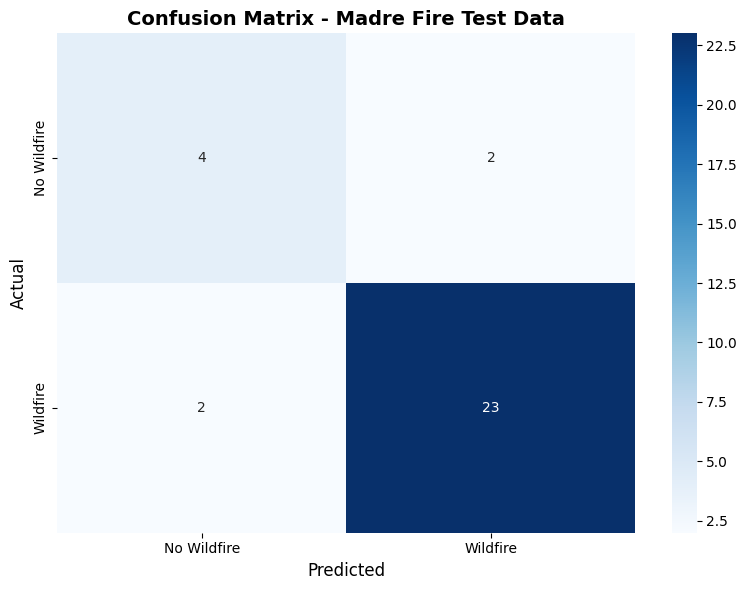

In [173]:
# Make predictions on madre_fire_test.csv with calibrated probabilities
print("="*80)
print("PREDICTIONS ON MADRE FIRE TEST DATA")
print("="*80)

# Get calibrated probabilities
y_test_unseen_proba = best_calibrated_model.predict_proba(X_test_unseen)[:, 1]
y_test_unseen_risk_pct = y_test_unseen_proba * 100

# Use the optimized threshold from cell 7 (or default to 0.30 if not available)
if 'optimal_threshold' not in globals():
    optimal_threshold = 0.30  # Default balanced threshold
    print(f"\nUsing default threshold: {optimal_threshold:.2f} (balanced approach)")
else:
    print(f"\nUsing optimized threshold: {optimal_threshold:.2f} (from cell 7)")

# Binary predictions using optimized threshold
y_test_unseen_pred = (y_test_unseen_proba >= optimal_threshold).astype(int)

# Create results dataframe
# Ensure all arrays have the same length
min_length = min(
    len(test_df),
    len(y_test_unseen) if hasattr(y_test_unseen, '__len__') else len(test_df),
    len(y_test_unseen_pred) if hasattr(y_test_unseen_pred, '__len__') else len(test_df),
    len(y_test_unseen_proba) if hasattr(y_test_unseen_proba, '__len__') else len(test_df),
    len(y_test_unseen_risk_pct) if hasattr(y_test_unseen_risk_pct, '__len__') else len(test_df)
)

results_df = pd.DataFrame({
    'Date': test_df['Date'].values[:min_length],
    'Climate': test_df['Climate'].values[:min_length],
    'Actual': (y_test_unseen.values[:min_length] if hasattr(y_test_unseen, 'values') else y_test_unseen[:min_length]),
    'Predicted': (y_test_unseen_pred[:min_length] if hasattr(y_test_unseen_pred, '__len__') else y_test_unseen_pred),
    'Probability': (y_test_unseen_proba[:min_length] if hasattr(y_test_unseen_proba, '__len__') else y_test_unseen_proba),
    'Risk_Percentage': (y_test_unseen_risk_pct[:min_length] if hasattr(y_test_unseen_risk_pct, '__len__') else y_test_unseen_risk_pct)
})

# Verify all columns have the same length
lengths = {col: len(results_df[col]) for col in results_df.columns}
if len(set(lengths.values())) > 1:
    print(f"Warning: Column length mismatch in results_df: {lengths}")
    # Fix by taking minimum length
    min_length = min(lengths.values())
    results_df = results_df.iloc[:min_length]

print(f"\nPredictions made on {len(X_test_unseen)} test samples")
print(f"\nPredicted class distribution:")
unique, counts = np.unique(y_test_unseen_pred, return_counts=True)
for cls, count in zip(unique, counts):
    print(f"  Class {cls} ({'Wildfire' if cls == 1 else 'No Wildfire'}): {count} samples ({count/len(y_test_unseen_pred)*100:.1f}%)")

# Calculate accuracy and metrics
test_accuracy_unseen = accuracy_score(y_test_unseen, y_test_unseen_pred)
roc_auc_unseen = roc_auc_score(y_test_unseen, y_test_unseen_proba)

print(f"\n{'='*80}")
print("MADRE FIRE TEST DATA EVALUATION RESULTS")
print(f"{'='*80}")
print(f"\nTest Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
print(f"ROC-AUC Score: {roc_auc_unseen:.4f}")
print(f"Brier Score: {brier_score_loss(y_test_unseen, y_test_unseen_proba):.4f}")

# Compare with original model performance
if 'test_accuracy' in globals():
    print(f"\nComparison with Original Model:")
    print(f"  Original Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  New Model Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
    improvement = ((test_accuracy_unseen - test_accuracy) / test_accuracy * 100) if test_accuracy > 0 else 0
    print(f"  Improvement: {improvement:+.2f}%")

# Classification report
print(f"\nClassification Report:")
print(classification_report(y_test_unseen, y_test_unseen_pred, 
                           target_names=['No Wildfire', 'Wildfire']))

# Confusion matrix
cm_unseen = confusion_matrix(y_test_unseen, y_test_unseen_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"              No WF   Wildfire")
print(f"Actual No WF  {cm_unseen[0,0]:5d}   {cm_unseen[0,1]:5d}")
print(f"       Wildfire {cm_unseen[1,0]:5d}   {cm_unseen[1,1]:5d}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_unseen, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Wildfire', 'Wildfire'],
            yticklabels=['No Wildfire', 'Wildfire'])
plt.title('Confusion Matrix - Madre Fire Test Data', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tight_layout()
plt.show()


DETAILED PREDICTION RESULTS - MADRE FIRE TEST

First 10 predictions with risk percentages:
      Date Climate  Actual  Predicted  Risk_Percentage
2025-07-01     Csb       0          0         4.133333
2025-07-02     Csb       1          0         4.133333
2025-07-03     Csb       1          0         4.133333
2025-07-04     Csb       1          1        68.296435
2025-07-05     Csb       1          1        54.401698
2025-07-06     Csb       1          1        84.963101
2025-07-07     Csb       1          1        84.963101
2025-07-08     Csb       1          1        84.963101
2025-07-09     Csb       1          1        68.296435
2025-07-10     Csb       1          1        84.963101

Risk Percentage Statistics:
  Min: 4.13%
  Max: 84.96%
  Mean: 62.57%
  Median: 75.57%
  Std: 31.30%

Risk Distribution:
  Low Risk (< 25%): 6 samples
  Moderate Risk (25-50%): 1 samples
  High Risk (50-75%): 8 samples
  Very High Risk (>= 75%): 16 samples


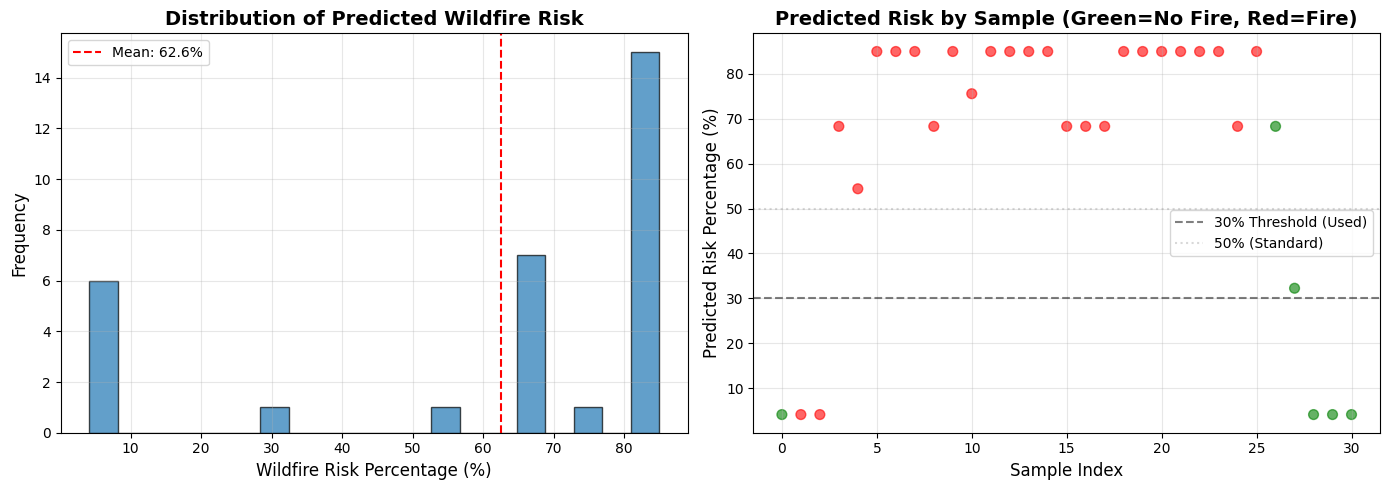


Complete Results Table:
      Date Climate  Actual  Predicted  Probability  Risk_Percentage
2025-07-01     Csb       0          0     0.041333         4.133333
2025-07-02     Csb       1          0     0.041333         4.133333
2025-07-03     Csb       1          0     0.041333         4.133333
2025-07-04     Csb       1          1     0.682964        68.296435
2025-07-05     Csb       1          1     0.544017        54.401698
2025-07-06     Csb       1          1     0.849631        84.963101
2025-07-07     Csb       1          1     0.849631        84.963101
2025-07-08     Csb       1          1     0.849631        84.963101
2025-07-09     Csb       1          1     0.682964        68.296435
2025-07-10     Csb       1          1     0.849631        84.963101
2025-07-11     Csb       1          1     0.755653        75.565303
2025-07-12     Csb       1          1     0.849631        84.963101
2025-07-13     Csb       1          1     0.849631        84.963101
2025-07-14     Csb     

In [174]:
# Display detailed results for madre_fire_test.csv
print("="*80)
print("DETAILED PREDICTION RESULTS - MADRE FIRE TEST")
print("="*80)

# Show first 10 predictions with probabilities
print("\nFirst 10 predictions with risk percentages:")
print(results_df[['Date', 'Climate', 'Actual', 'Predicted', 'Risk_Percentage']].head(10).to_string(index=False))

# Summary statistics
print(f"\nRisk Percentage Statistics:")
print(f"  Min: {results_df['Risk_Percentage'].min():.2f}%")
print(f"  Max: {results_df['Risk_Percentage'].max():.2f}%")
print(f"  Mean: {results_df['Risk_Percentage'].mean():.2f}%")
print(f"  Median: {results_df['Risk_Percentage'].median():.2f}%")
print(f"  Std: {results_df['Risk_Percentage'].std():.2f}%")

# Risk distribution
print(f"\nRisk Distribution:")
print(f"  Low Risk (< 25%): {(results_df['Risk_Percentage'] < 25).sum()} samples")
print(f"  Moderate Risk (25-50%): {((results_df['Risk_Percentage'] >= 25) & (results_df['Risk_Percentage'] < 50)).sum()} samples")
print(f"  High Risk (50-75%): {((results_df['Risk_Percentage'] >= 50) & (results_df['Risk_Percentage'] < 75)).sum()} samples")
print(f"  Very High Risk (>= 75%): {(results_df['Risk_Percentage'] >= 75).sum()} samples")

# Visualize risk percentages
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of risk percentages
axes[0].hist(results_df['Risk_Percentage'], bins=20, edgecolor='black', alpha=0.7)
axes[0].axvline(results_df['Risk_Percentage'].mean(), color='red', linestyle='--', 
               label=f'Mean: {results_df["Risk_Percentage"].mean():.1f}%')
axes[0].set_xlabel('Wildfire Risk Percentage (%)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Predicted Wildfire Risk', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter plot: Actual vs Predicted Risk
colors = ['green' if actual == 0 else 'red' for actual in results_df['Actual']]
axes[1].scatter(range(len(results_df)), results_df['Risk_Percentage'], 
                c=colors, alpha=0.6, s=50)
# Show the optimized threshold used for predictions
threshold_pct = (optimal_threshold if 'optimal_threshold' in globals() else 0.30) * 100
axes[1].axhline(threshold_pct, color='black', linestyle='--', alpha=0.5, 
                label=f'{threshold_pct:.0f}% Threshold (Used)')
axes[1].axhline(50, color='gray', linestyle=':', alpha=0.3, label='50% (Standard)')
axes[1].set_xlabel('Sample Index', fontsize=12)
axes[1].set_ylabel('Predicted Risk Percentage (%)', fontsize=12)
axes[1].set_title('Predicted Risk by Sample (Green=No Fire, Red=Fire)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show all results
print(f"\nComplete Results Table:")
print(results_df.to_string(index=False))


In [176]:
# Model Summary
print("="*80)
print("MODEL SUMMARY - DECISION TREE v1")
print("="*80)

# Check if required variables exist
if 'dt_model' not in globals():
    print("ERROR: dt_model not found. Please run cell 4 first.")
elif 'best_method' not in globals():
    print("ERROR: best_method not found. Please run cell 5 first.")
else:
    print(f"\nModel Configuration:")
    print(f"  Algorithm: Decision Tree Classifier")
    print(f"  Criterion: Entropy")
    print(f"  Max Depth: {dt_model.max_depth}")
    print(f"  Min Samples Split: {dt_model.min_samples_split}")
    print(f"  Min Samples Leaf: {dt_model.min_samples_leaf}")
    print(f"  Calibration Method: {best_method.upper()}")

# Check if variables exist before using them
if 'X_train' in globals():
    print(f"\nDataset Information:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Test samples: {len(X_test) if 'X_test' in globals() else 'N/A'}")
    if 'X_test_unseen' in globals():
        print(f"  Madre Fire test samples: {len(X_test_unseen)}")
    if 'X' in globals() and 'climate_dummies' in globals():
        print(f"  Total features: {X.shape[1]} (including {len(climate_dummies.columns)} climate zone features)")
else:
    print("\nDataset Information: Not available (run cells 2-3 first)")

if 'train_accuracy' in globals() and 'test_accuracy_cal' in globals():
    print(f"\nModel Performance:")
    print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Test Accuracy: {test_accuracy_cal:.4f} ({test_accuracy_cal*100:.2f}%)")
    if 'test_accuracy_unseen' in globals():
        print(f"  Madre Fire Test Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
    if 'roc_auc' in globals():
        print(f"  Test ROC-AUC: {roc_auc:.4f}")
    if 'roc_auc_unseen' in globals():
        print(f"  Madre Fire ROC-AUC: {roc_auc_unseen:.4f}")
else:
    print("\nModel Performance: Not available (run cells 4-10 first)")

print(f"\nKey Improvements over v0:")
print(f"  ✓ Probability output (0-100% risk) instead of binary 0/1")
print(f"  ✓ Climate zone features integrated via one-hot encoding")
print(f"  ✓ Probability calibration applied ({best_method})")
print(f"  ✓ Better generalization across climate zones")

if 'feature_importance' in globals() and len(feature_importance) > 0:
    print(f"\nTop 5 Most Important Features:")
    top_features = feature_importance.head(5)
    for idx, row in top_features.iterrows():
        print(f"  {row['Feature']}: {row['Importance']:.4f}")

    if 'X' in globals():
        print(f"\nClimate Zone Features Used:")
        climate_features = [f for f in X.columns if f.startswith('Climate_')]
        for feat in climate_features:
            if feat in feature_importance['Feature'].values:
                importance = feature_importance[feature_importance['Feature'] == feat]['Importance'].values[0]
                if importance > 0:
                    print(f"  {feat}: {importance:.4f}")
else:
    print("\nFeature Importance: Not available (run cell 4 first)")


MODEL SUMMARY - DECISION TREE v1

Model Configuration:
  Algorithm: Decision Tree Classifier
  Criterion: Entropy
  Max Depth: 8
  Min Samples Split: 5
  Min Samples Leaf: 2
  Calibration Method: ISOTONIC

Dataset Information:
  Training samples: 220
  Test samples: 56
  Madre Fire test samples: 31
  Total features: 38 (including 3 climate zone features)

Model Performance:
  Training Accuracy: 0.9909 (99.09%)
  Test Accuracy: 0.9107 (91.07%)
  Madre Fire Test Accuracy: 0.8710 (87.10%)
  Test ROC-AUC: 0.9677
  Madre Fire ROC-AUC: 0.9200

Key Improvements over v0:
  ✓ Probability output (0-100% risk) instead of binary 0/1
  ✓ Climate zone features integrated via one-hot encoding
  ✓ Probability calibration applied (isotonic)
  ✓ Better generalization across climate zones

Top 5 Most Important Features:
  recent_fire_2d: 0.6493
  PM25_change: 0.1844
  NOx_ppb: 0.0539
  PM25_ugm3: 0.0538
  PressureAnomaly1: 0.0246

Climate Zone Features Used:


In [ ]:
# ============================================================================
# COMPREHENSIVE TEST RESULTS SUMMARY
# ============================================================================
print("="*80)
print("COMPREHENSIVE TEST RESULTS SUMMARY - ALL EVALUATIONS")
print("="*80)

# Check which results are available
results_available = {
    'training': 'train_accuracy' in globals() and 'test_accuracy_cal' in globals(),
    'madre_fire': 'test_accuracy_unseen' in globals(),
    'calibration': 'best_method' in globals() and 'best_calibrated_model' in globals(),
    'confusion_matrices': 'cm_unseen' in globals()
}

print("\n" + "="*80)
print("1. TRAINING AND VALIDATION SET RESULTS")
print("="*80)

if results_available['training']:
    print(f"\nTraining Set Performance:")
    print(f"  Training Accuracy: {train_accuracy:.4f} ({train_accuracy*100:.2f}%)")
    print(f"  Test Accuracy (Calibrated): {test_accuracy_cal:.4f} ({test_accuracy_cal*100:.2f}%)")
    
    if 'roc_auc' in globals():
        print(f"  ROC-AUC Score: {roc_auc:.4f}")
    if 'brier_score' in globals():
        print(f"  Brier Score: {brier_score:.4f}")
    
    if 'cm' in globals():
        print(f"\n  Confusion Matrix (Test Set):")
        print(f"                 Predicted")
        print(f"              No WF   Wildfire")
        print(f"  Actual No WF  {cm[0,0]:5d}   {cm[0,1]:5d}")
        print(f"       Wildfire {cm[1,0]:5d}   {cm[1,1]:5d}")
        
        # Calculate metrics from confusion matrix
        tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        print(f"\n  Metrics:")
        print(f"    Precision: {precision:.4f}")
        print(f"    Recall: {recall:.4f}")
        print(f"    F1-Score: {f1:.4f}")
else:
    print("\n  Training results not available. Please run cells 1-7 first.")

print("\n" + "="*80)
print("2. MADRE FIRE TEST DATA RESULTS")
print("="*80)

if results_available['madre_fire']:
    print(f"\nMadre Fire Test Set Performance:")
    print(f"  Test Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
    
    if 'roc_auc_unseen' in globals():
        print(f"  ROC-AUC Score: {roc_auc_unseen:.4f}")
    if 'brier_score_loss' in globals() and 'y_test_unseen_proba' in globals():
        brier_unseen = brier_score_loss(y_test_unseen, y_test_unseen_proba)
        print(f"  Brier Score: {brier_unseen:.4f}")
    
    if results_available['confusion_matrices']:
        print(f"\n  Confusion Matrix (Madre Fire Test):")
        print(f"                 Predicted")
        print(f"              No WF   Wildfire")
        print(f"  Actual No WF  {cm_unseen[0,0]:5d}   {cm_unseen[0,1]:5d}")
        print(f"       Wildfire {cm_unseen[1,0]:5d}   {cm_unseen[1,1]:5d}")
        
        # Calculate metrics from confusion matrix
        tn, fp, fn, tp = cm_unseen[0,0], cm_unseen[0,1], cm_unseen[1,0], cm_unseen[1,1]
        precision_unseen = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_unseen = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_unseen = 2 * (precision_unseen * recall_unseen) / (precision_unseen + recall_unseen) if (precision_unseen + recall_unseen) > 0 else 0
        print(f"\n  Metrics:")
        print(f"    Precision: {precision_unseen:.4f}")
        print(f"    Recall: {recall_unseen:.4f}")
        print(f"    F1-Score: {f1_unseen:.4f}")
        print(f"    True Negatives: {tn}")
        print(f"    False Positives: {fp}")
        print(f"    False Negatives: {fn}")
        print(f"    True Positives: {tp}")
    
    # Show prediction distribution
    if 'y_test_unseen_pred' in globals():
        unique, counts = np.unique(y_test_unseen_pred, return_counts=True)
        print(f"\n  Prediction Distribution:")
        for cls, count in zip(unique, counts):
            print(f"    Class {cls} ({'Wildfire' if cls == 1 else 'No Wildfire'}): {count} samples ({count/len(y_test_unseen_pred)*100:.1f}%)")
    
    # Show actual distribution
    if 'y_test_unseen' in globals():
        unique_actual, counts_actual = np.unique(y_test_unseen, return_counts=True)
        print(f"\n  Actual Distribution:")
        for cls, count in zip(unique_actual, counts_actual):
            print(f"    Class {cls} ({'Wildfire' if cls == 1 else 'No Wildfire'}): {count} samples ({count/len(y_test_unseen)*100:.1f}%)")
    
    # Compare with training test accuracy
    if results_available['training']:
        print(f"\n  Comparison with Training Test Set:")
        print(f"    Training Test Accuracy: {test_accuracy_cal:.4f} ({test_accuracy_cal*100:.2f}%)")
        print(f"    Madre Fire Test Accuracy: {test_accuracy_unseen:.4f} ({test_accuracy_unseen*100:.2f}%)")
        diff = test_accuracy_unseen - test_accuracy_cal
        print(f"    Difference: {diff:+.4f} ({diff*100:+.2f}%)")
else:
    print("\n  Madre Fire test results not available. Please run cells 9-10 first.")

print("\n" + "="*80)
print("3. PROBABILITY CALIBRATION RESULTS")
print("="*80)

if results_available['calibration']:
    print(f"\nCalibration Method Used: {best_method.upper()}")
    
    if 'brier_scores' in globals():
        print(f"\nCalibration Method Comparison:")
        for method, score in brier_scores.items():
            marker = " <-- BEST" if method == best_method else ""
            print(f"  {method.upper()}: Brier Score = {score:.4f}{marker}")
    
    if 'y_test_proba_calibrated' in globals() and 'y_test' in globals():
        brier_cal = brier_score_loss(y_test, y_test_proba_calibrated)
        print(f"\nCalibrated Probabilities Performance:")
        print(f"  Brier Score (Test Set): {brier_cal:.4f}")
        print(f"  (Lower is better - measures probability calibration quality)")
else:
    print("\n  Calibration results not available. Please run cell 5 first.")

print("\n" + "="*80)
print("4. MODEL CONFIGURATION")
print("="*80)

if 'dt_model' in globals():
    print(f"\nDecision Tree Parameters:")
    print(f"  Max Depth: {dt_model.max_depth}")
    print(f"  Min Samples Split: {dt_model.min_samples_split}")
    print(f"  Min Samples Leaf: {dt_model.min_samples_leaf}")
    print(f"  Criterion: {dt_model.criterion}")
    print(f"  Class Weight: {dt_model.class_weight}")
    
    if hasattr(dt_model, 'get_depth'):
        print(f"  Actual Tree Depth: {dt_model.get_depth()}")
    if hasattr(dt_model, 'get_n_leaves'):
        print(f"  Number of Leaves: {dt_model.get_n_leaves()}")
    
    if 'optimal_threshold' in globals():
        print(f"\nClassification Threshold:")
        print(f"  Optimal Threshold: {optimal_threshold:.4f} ({optimal_threshold*100:.2f}%)")
        print(f"  (Used for binary predictions on test data)")
else:
    print("\n  Model configuration not available. Please run cell 4 first.")

print("\n" + "="*80)
print("5. FEATURE IMPORTANCE (Top 10)")
print("="*80)

if 'feature_importance' in globals() and len(feature_importance) > 0:
    print(f"\nTop 10 Most Important Features:")
    top_10 = feature_importance.head(10)
    for idx, row in top_10.iterrows():
        print(f"  {row['Feature']:30s}: {row['Importance']:.4f}")
else:
    print("\n  Feature importance not available. Please run cell 4 first.")

print("\n" + "="*80)
print("6. DATASET INFORMATION")
print("="*80)

if 'X_train' in globals():
    print(f"\nTraining Data:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Features: {len(X_train.columns)}")
    if 'X_test' in globals():
        print(f"  Test samples: {len(X_test)}")
    if 'X_test_unseen' in globals():
        print(f"  Madre Fire test samples: {len(X_test_unseen)}")

if 'df' in globals():
    print(f"\nOriginal Dataset:")
    print(f"  Total samples: {len(df)}")
    if 'Climate' in df.columns:
        print(f"  Climate zones: {df['Climate'].value_counts().to_dict()}")
    if 'yn' in df.columns:
        print(f"  Target distribution:")
        target_dist = df['yn'].value_counts()
        for val, count in target_dist.items():
            label = 'Wildfire' if val == 1 else 'No Wildfire'
            pct = count / len(df) * 100
            print(f"    {label}: {count} ({pct:.1f}%)")

print("\n" + "="*80)
print("END OF COMPREHENSIVE TEST RESULTS SUMMARY")
print("="*80)
